In [1]:
import pandas as pd
from pathlib import Path
from scipy import stats

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve,RepeatedKFold

from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from imblearn import over_sampling as ovs
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer,quantile_transform,PowerTransformer

%matplotlib inline

In [2]:
sns.set_context(context="paper")
def learn_curves(estimator, features, target, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, features, target,train_sizes = np.linspace(.1, 1.0, 10),
                                                 cv = cv, scoring = 'r2',n_jobs=-1)
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    
    plt.plot(train_sizes, np.sqrt(train_scores_mean), label = 'Training error')
    plt.plot(train_sizes, np.sqrt(validation_scores_mean), label = 'Validation error')

    plt.ylabel('R2', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curve'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(-1,3)

In [3]:

#dataframe final
df_final = pd.read_csv("../data/DF_train300_skempiAB_modeller_final.csv",index_col=0)

#drop_ddg = (df_final.ddG_exp.abs() > 4.3)
#df_final = df_final.loc[-drop_ddg]


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns


In [4]:
import math
def deltaG_to_Kd(delg):
    Kd_value = math.exp((delg*1000)/(1.98*298.15))
    return Kd_value

In [5]:
X = df_final.drop('ddG_exp',axis=1).astype(float)
y = df_final['ddG_exp']

In [6]:
# binned split
bins = np.linspace(0, len(X), 200)
y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned,random_state=1)                                                    

/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


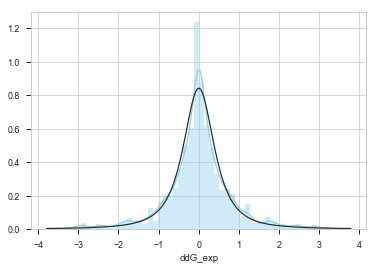

In [7]:
#sns.distplot( y_test , fit=stats.laplace,color="red", label="ddG_exp_test")
sns.distplot( y_train , fit=stats.nct,color="skyblue", label="ddG_exp_train")

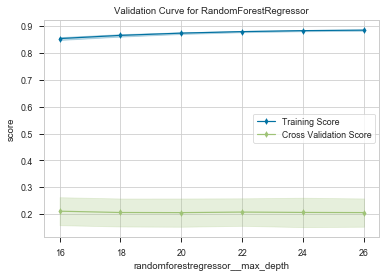

In [21]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
selector = VarianceThreshold()

#2)
rf_model = RandomForestRegressor(random_state=1212,n_estimators=50)
#3) Crear pipeline


pipeline1 = make_pipeline(selector,rf_model)

#regr_trans = TransformedTargetRegressor(
#    regressor=pipeline1, transformer=PowerTransformer())

cv = RepeatedKFold(n_splits=5,n_repeats=2,random_state=13)

# Extract the instances and target
viz = ValidationCurve(
    pipeline1, njobs=-1,param_name="randomforestregressor__max_depth",
    param_range=[16,18,20,22,24,26], cv=cv, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()


In [32]:
#1)
selector = VarianceThreshold()
#2)
rf_model = RandomForestRegressor()
#3) Crear pipeline


pipeline1 = make_pipeline(selector,rf_model)
# grid params
param_grid = {
    'randomforestregressor__bootstrap': [True],
    'randomforestregressor__max_depth': [16],
    'randomforestregressor__max_features': ['sqrt'],
    'randomforestregressor__max_leaf_nodes':[None],
    'randomforestregressor__min_samples_leaf': [10],
    'randomforestregressor__min_samples_split': [20],
    'randomforestregressor__n_estimators': [100],
    'randomforestregressor__random_state':[1212],
    'variancethreshold__threshold':[0.] }

cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid1 = GridSearchCV(pipeline1, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)

grid1.fit(X_train,y_train)

Fitting 50 folds for each of 1 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  50 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    2.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.5s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a28887ac8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurit...='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'randomforestregressor__bootstrap': [True], 'randomforestregressor__max_depth': [16], 'randomforestregressor__max_features': ['sqrt'], 'randomforestregressor__max_leaf_nodes': [None], 'randomforestregressor__min_samples_leaf': [10], 'randomforestregressor__min_samples_split': [20], 'randomforestregressor__n_estimators': [100], 'randomforestregressor__random_state': [1212], 'variancethreshold_

In [33]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 0.739010 +/- 0.269661
CV train RMSE 0.623299 +/- 0.115078
CV test r2 0.174303 +/- 0.032082
CV train r2 0.414030 +/- 0.009237
0.23972745269633453
 {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 16, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__min_samples_leaf': 10, 'randomforestregressor__min_samples_split': 20, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 1212, 'variancethreshold__threshold': 0.0}

RMSE for test dataset: 0.76
RMSE for train dataset: 0.62
pearson corr  0.577723
R2 test 0.2407343513767365
R2 train 0.4285140109210469


0.300056355076

In [ ]:
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 8,
 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__min_samples_leaf': 13, 'randomforestregressor__min_samples_split': 11,
 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 1212,
 'variancethreshold__threshold': 0.0}



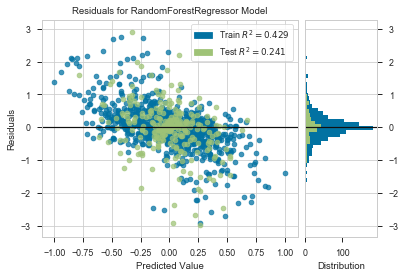

In [34]:
visualizer = ResidualsPlot(grid1.best_estimator_)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

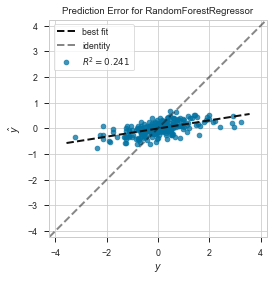

In [35]:
perror = PredictionError(grid1.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof() 

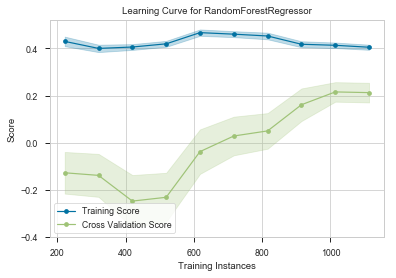

In [168]:
viz = LearningCurve(grid1.best_estimator_, cv=cv, n_jobs=-1,scoring='r2',train_sizes=np.linspace(0.2, 1.0, 10))
viz.fit(X, y)
#plt.ylim(0,-4)
viz.poof()

In [174]:
final_rf = grid1.best_estimator_.fit(X,y)

In [175]:
# save final model

joblib.dump(final_rf, 'RFmodel_train15skempiAB_FINAL.pkl')

['RFmodel_train15skempiAB_FINAL.pkl']

Text(4.5, -0.5, 'RMSE = 0.755')

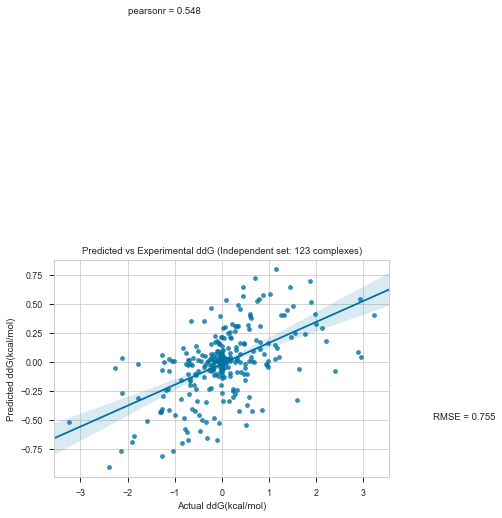

In [177]:
rmse_test = np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 3)
df_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_test_pred, "Actual ddG(kcal/mol)": y_test.values})
pearsonr_test = round(df_pred.corr().iloc[0,1],3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_pred)
plt.title("Predicted vs Experimental ddG (Independent set: 123 complexes)")

plt.text(-2,3,"pearsonr = %s" %pearsonr_test)
plt.text(4.5,-0.5,"RMSE = %s" %rmse_test)

#plt.savefig("RFmodel_300_testfit.png",dpi=600)

Text(0.5, 1.0, 'Predicted vs Experimental ddG (Train set: 492 complexes)')

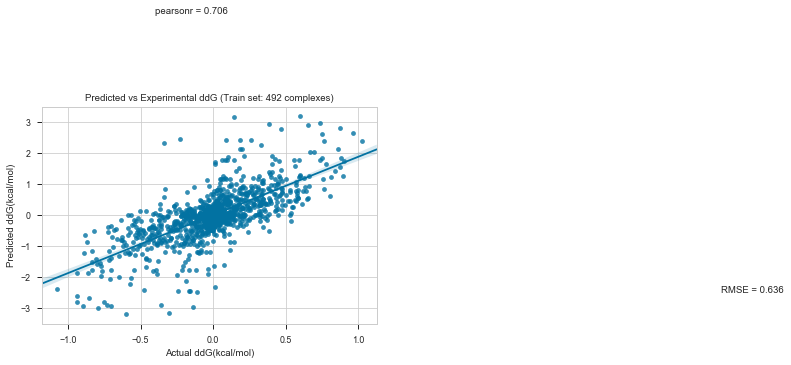

In [179]:
df_train_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_train, "Actual ddG(kcal/mol)": y_train_pred})
pearsonr_train = round(df_train_pred.corr().iloc[0,1],3)
rmse_train = np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_train_pred)

plt.text(-0.4,6.5,"pearsonr = %s" %pearsonr_train)
plt.text(3.5,-2.5,"RMSE = %s" %rmse_train)
plt.title("Predicted vs Experimental ddG (Train set: 492 complexes)")
#plt.savefig("RFmodel_300_trainfit.png",dpi=600)


In [36]:
rf_model = grid1.best_estimator_.named_steps["randomforestregressor"]
importances = list(rf_model.feature_importances_)
feature_list = df_final.columns
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: vdw_R_change         Importance: 0.073
Variable: hbond_R_change       Importance: 0.0728
Variable: vdw_clash_A_change   Importance: 0.0419
Variable: weak_hbond_R_change  Importance: 0.0413
Variable: clash_R_change       Importance: 0.0384
Variable: weak_polar_T_change  Importance: 0.0292
Variable: polar_Q_change       Importance: 0.0269
Variable: vdw_clash_V_change   Importance: 0.026
Variable: vdw_V_change         Importance: 0.0254
Variable: proximal_Q_change    Importance: 0.0242
Variable: carbonyl_S_change    Importance: 0.0222
Variable: proximal_V_change    Importance: 0.0215
Variable: proximal_T_change    Importance: 0.0199
Variable: vdw_clash_R_change   Importance: 0.0196
Variable: covalent_R_change    Importance: 0.0188
Variable: xbond_R_change       Importance: 0.0187
Variable: proximal_R_change    Importance: 0.0179
Variable: ionic_S_change       Importance: 0.0168
Variable: covalent_V_change    Importance: 0.0164
Variable: carbonyl_R_change    Importance: 0.0159
Va

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [37]:
rf_model.feature_importances_[idx_features]

NameError: name 'idx_features' is not defined

Text(0.5, 0, 'Feature importance')

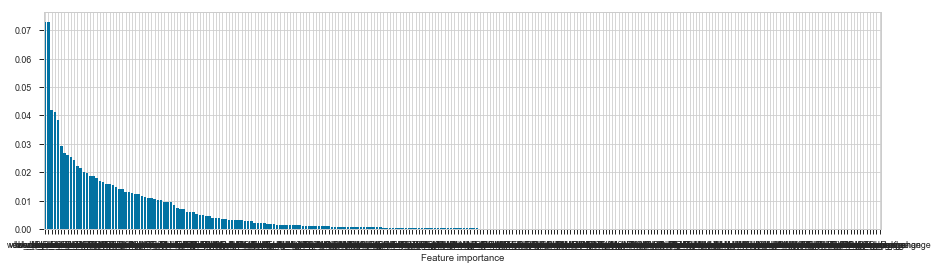

In [38]:
idx_features = rf_model.feature_importances_.argsort()[::-1]
plt.figure(figsize=(15,4))

plt.bar(np.arange(len(idx_features)), rf_model.feature_importances_[idx_features])
plt.xticks(range(len(feature_list)),feature_list[idx_features])
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel(u"Feature importance")
#plt.savefig("RFmodel_300_50features",dpi=600,bbox_inches="tight")